In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
combined_data = pd.read_csv("datasets/feature_engineered_aqi_data_local.csv")

In [27]:
combined_data.head()

,date,city,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,uv_index_clear_sky,uv_index,dust,aerosol_optical_depth,us_aqi,hour_sin,hour_cos,month_sin,month_cos,day_of_week,year
0,2023-06-01 06:00:00+00:00,dhaka,51.3,34.1,369.0,17.9,8.6,44.0,0.15,0.15,1.0,1.17,152.57675,1.000000,6.123234e-17,1.224647e-16,-1.0,3,2023
1,2023-06-01 07:00:00+00:00,dhaka,50.2,32.5,381.0,19.3,10.4,53.0,0.65,0.50,1.0,1.27,151.45615,0.965926,-2.588190e-01,1.224647e-16,-1.0,3,2023
2,2023-06-01 08:00:00+00:00,dhaka,51.3,32.9,397.0,21.1,12.9,67.0,1.75,1.55,1.0,1.26,150.46272,0.866025,-5.000000e-01,1.224647e-16,-1.0,3,2023
3,2023-06-01 09:00:00+00:00,dhaka,58.4,37.8,410.0,21.4,15.5,92.0,3.25,3.20,1.0,1.27,148.54167,0.707107,-7.071068e-01,1.224647e-16,-1.0,3,2023
4,2023-06-01 10:00:00+00:00,dhaka,71.5,46.9,405.0,18.0,16.0,121.0,4.80,4.65,1.0,1.34,146.14584,0.500000,-8.660254e-01,1.224647e-16,-1.0,3,2023


In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
combined_data['city_encoded'] = le.fit_transform(combined_data['city'])

In [30]:
X = combined_data[[col for col in combined_data.columns if col not in ["date", "us_aqi", "city"]]]
y = combined_data["us_aqi"]

In [31]:
X.shape, y.shape

((54792, 17), (54792,))

In [32]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=43)

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [34]:
f'Coefficient of determination R^2 on train set {tree.score(X_train, y_train)}'
# must be close to 1, 1 is perfect fit

'Coefficient of determination R^2 on train set 1.0'

In [35]:
f'Coefficient of determination R^2 on test set {tree.score(X_val, y_val)}'

'Coefficient of determination R^2 on test set 0.8570538024284965'

In [36]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(tree, X, y, cv = 3)

In [37]:
score.mean()

np.float64(0.6713345919401611)

In [38]:
pred = tree.predict(X_test)

C:\Users\stasn\AppData\Local\Temp\ipykernel_3264\2485339681.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - pred)


<Axes: xlabel='us_aqi', ylabel='Density'>

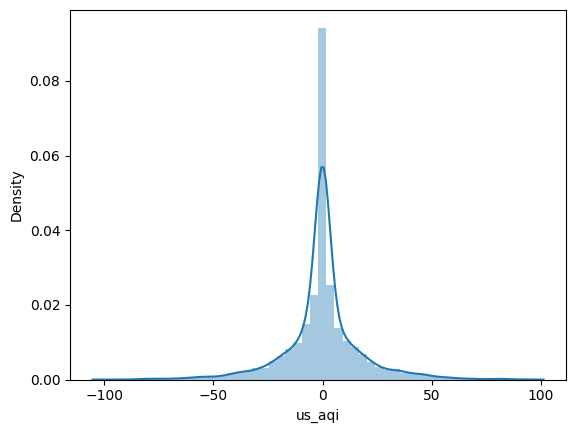

In [39]:
sns.distplot(y_test - pred)

In [40]:
params = {
    'splitter': ['best', 'random'],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_samples_leaf': list(range(1,6)),
    'min_weight_fraction_leaf': [i/10 for i in range(1, 5)],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70]
}

In [42]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(tree, params, scoring='neg_mean_squared_error', cv=5)
search.fit(X_train_val, y_train_val)

,estimator,DecisionTreeRegressor()
,param_grid,"{'max_depth': [3, 4, ...], 'max_leaf_nodes': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_weight_fraction_leaf': [0.1, 0.2, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'squared_error'


In [43]:
search.best_params_

{'max_depth': 3,
 'max_leaf_nodes': 30,
 'min_samples_leaf': 2,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [44]:
search.best_score_

np.float64(-435.7444291245441)

C:\Users\stasn\AppData\Local\Temp\ipykernel_3264\2278970355.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-pred)


<Axes: xlabel='us_aqi', ylabel='Density'>

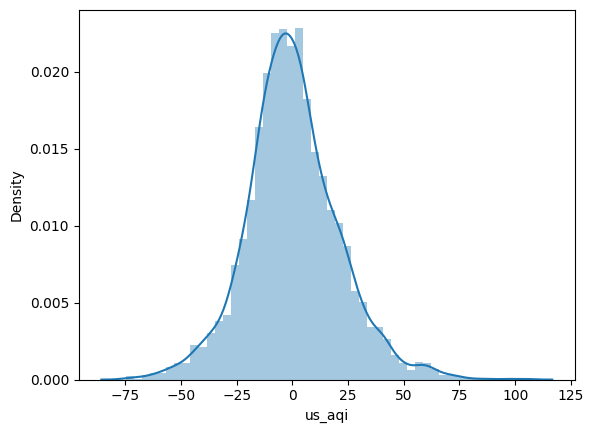

In [45]:
pred = search.predict(X_test)
sns.distplot(y_test-pred)

In [46]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 15.853850125034198
Mean Sq Error: 439.44779522626146
Root Mean Error: 20.963010166153655


In [47]:
search.best_estimator_

,criterion,'squared_error'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.1
,max_features,None
,random_state,None
,max_leaf_nodes,30
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [48]:
import pickle
pickle.dump(search, open('models/d-tree.pkl', 'wb'))